In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications.densenet import preprocess_input

# Load and prepare the dataset

In [24]:
batch_size = 16
img_height = 224
img_width = 224

In [25]:
data_dir = "D:\\ISEN\\M1\\Projet M1\\DLBCL-Morph\\Patches\\HE"
data_dir = pathlib.Path(data_dir)
list_ds = tf.data.Dataset.list_files(str(data_dir / '*/*'), shuffle=False)
list_ds = list_ds.shuffle(len(list_ds), reshuffle_each_iteration=False)
image_count = len(list_ds)
print(image_count)
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

30007
24006
6001


In [26]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])


def process_path(file_path):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, img


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [27]:
def data_augmentation(batch, blur_range=(0.0, 0.2*255.0), noise_range=(0.0, 0.2*255.0)):
    # Apply random Gaussian blur and noise to each image in the batch
    def augment_image(image):
        # Apply Gaussian blur with random severity within `blur_range`
        blur_sigma = np.random.uniform(*blur_range)
        image = tfa.image.gaussian_filter2d(image, filter_shape=(3, 3), sigma=blur_sigma)

        # Add Gaussian noise with random severity within `noise_range`
        noise_scale = np.random.uniform(*noise_range)
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise_scale)
        image = tf.add(image, noise)

        return image

    augmented_batch = tf.map_fn(augment_image, batch)
    return augmented_batch

In [28]:
train_ds = train_ds.batch(batch_size)

# Extract one batch and apply data augmentation and data preprocessing to it

In [29]:
batch_ = next(iter(train_ds))[0]
augmented_batch_ = data_augmentation(batch_)
preprocessed_augmented_batch = preprocess_input(augmented_batch_)

In [30]:
def show_batch(image_batch):
    plt.figure(figsize=(10, 10))
    for n in range(16):
        plt.subplot(4, 4, n + 1)
        # if the image is a tensor, convert it to a numpy array
        if isinstance(image_batch[n], tf.Tensor):
            plt.imshow(image_batch[n].numpy().astype("uint8"))
        else:
            plt.imshow(image_batch[n].astype("uint8"))
        plt.axis("off")

## Original batch

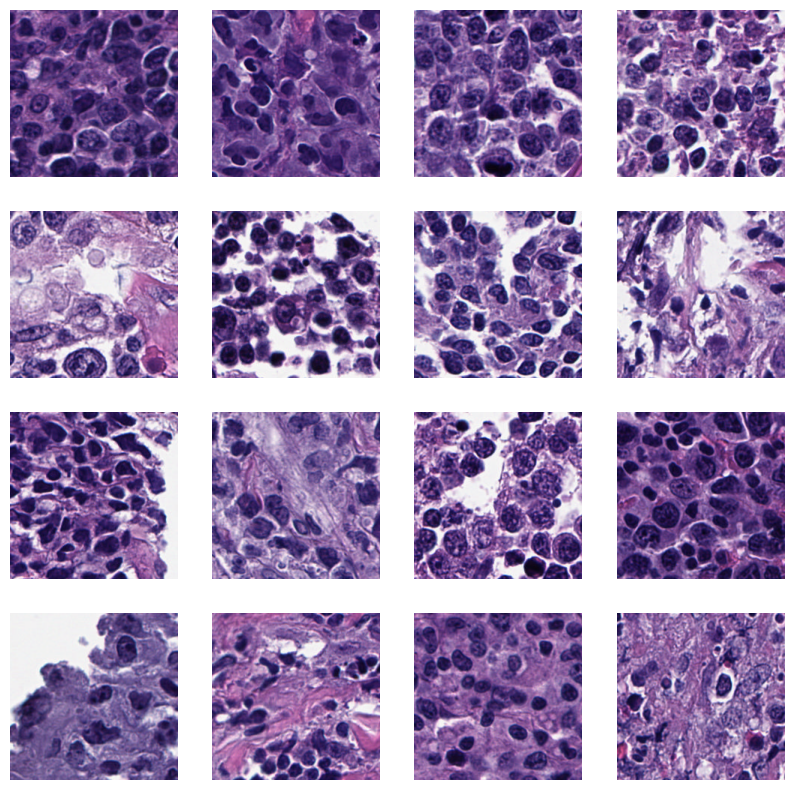

In [31]:
show_batch(batch_)

## Augmented batch

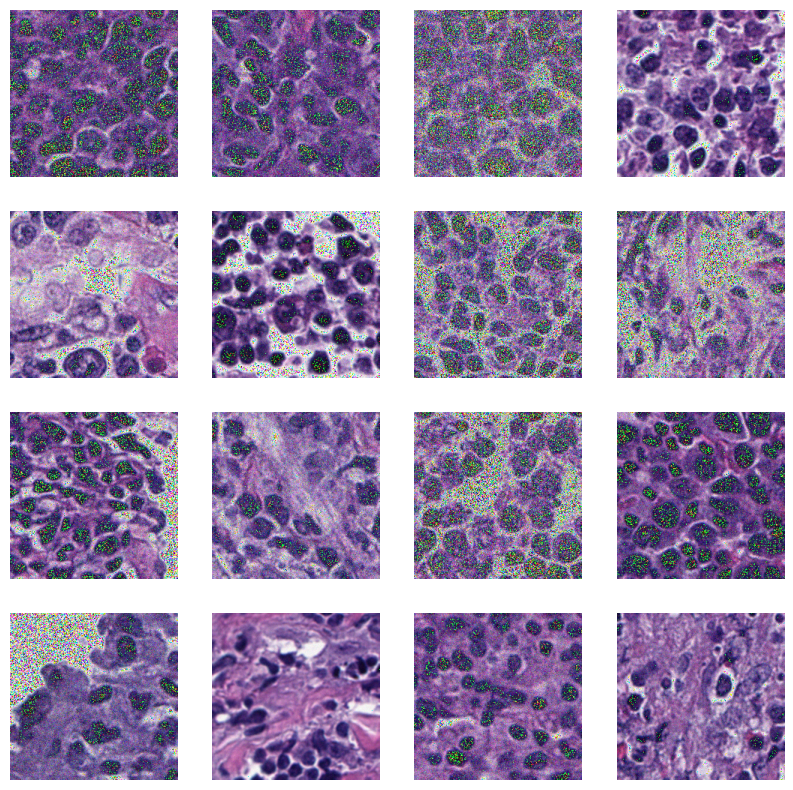

In [32]:
show_batch(augmented_batch_)

## Preprocessed augmented batch

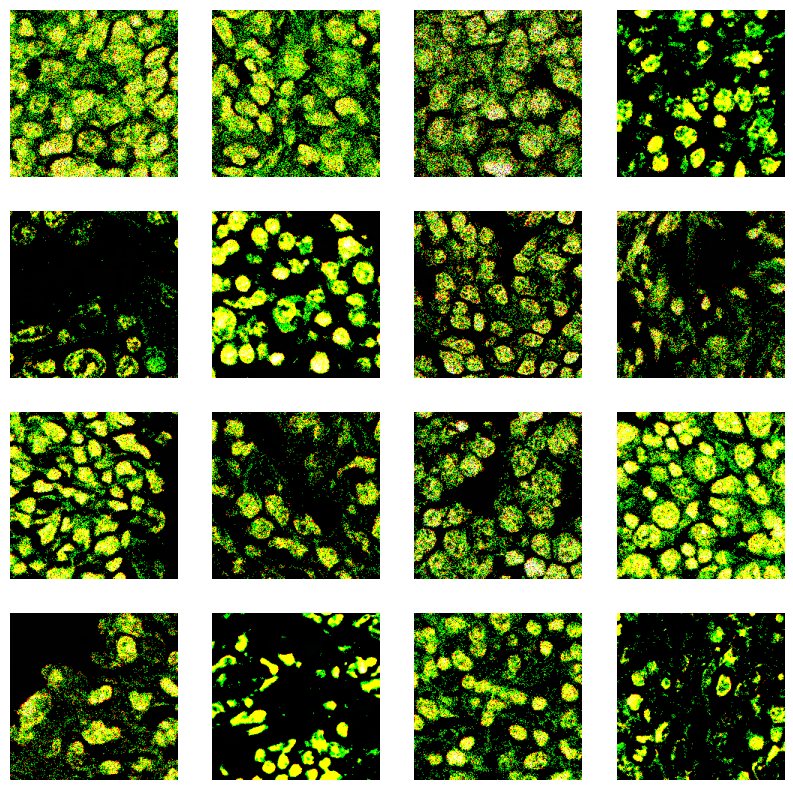

In [33]:
show_batch(preprocessed_augmented_batch)

# Load the model and show the output for the corresponding batch

In [34]:
model = tf.keras.models.load_model("../Models/Model_16_1e-05_19042023_093832/2")

In [35]:
output_batch = model.predict(preprocessed_augmented_batch)

1/1 [==============================] - 4s 4s/step


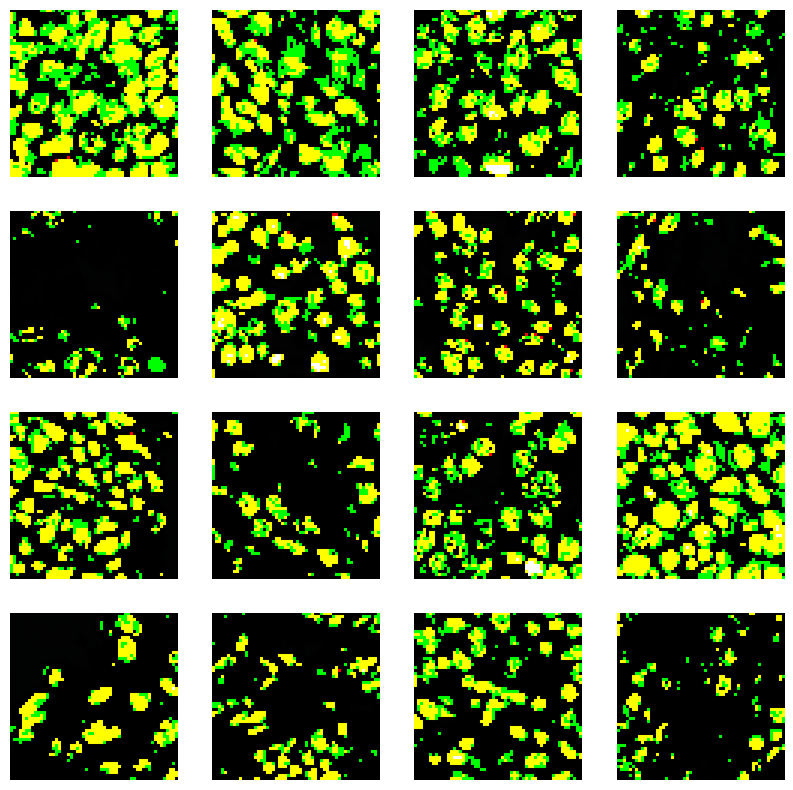

In [36]:
show_batch(output_batch)

In [37]:
# rescale the output to the range [0, 255]
output_batch = (output_batch - output_batch.min()) / (output_batch.max() - output_batch.min())
output_batch = output_batch * 255

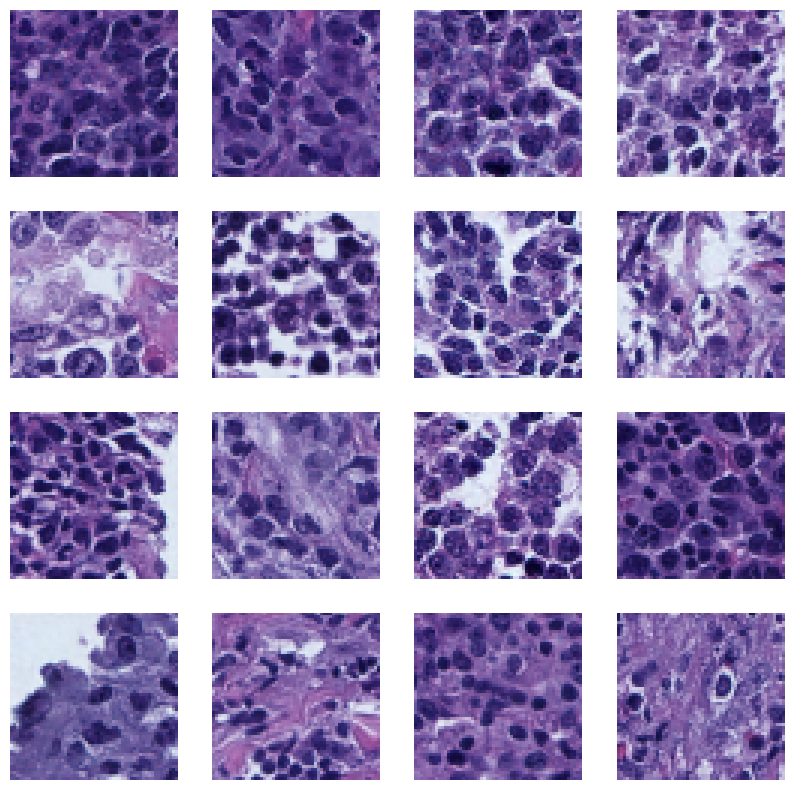

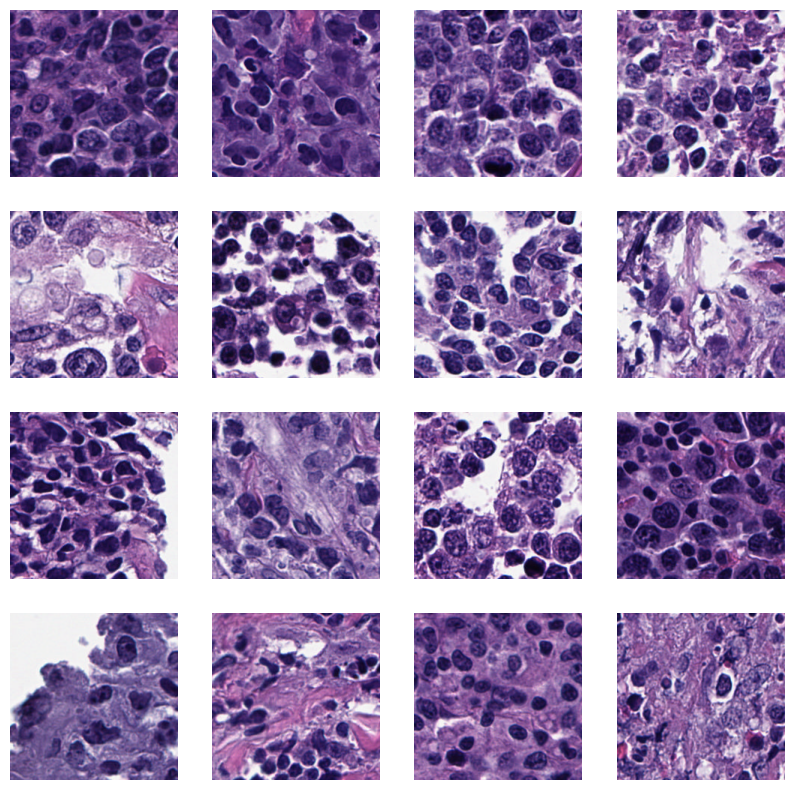

In [38]:
show_batch(output_batch)
show_batch(batch_)

# Show the extracted features from the output layer of the encoder part

In [39]:
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
ae_feature_extractor = Model(inputs=model.layers[-2].inputs, outputs=GlobalAveragePooling2D()(model.layers[-2].outputs[-1]))

In [40]:
batch_features = ae_feature_extractor.predict(preprocessed_augmented_batch)

1/1 [==============================] - 2s 2s/step


In [41]:
# Convert batch_features into a pandas dataframe
import pandas as pd
df = pd.DataFrame(batch_features)

In [42]:
df = df.rename(columns={i: f"feature_{i}" for i in range(len(df.columns))})
df = df.rename(index={i: f"patch_{i}" for i in range(16)})

In [43]:
df

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
patch_0    0.099869   0.124265   0.016936   0.035611   0.185664   0.910291   
patch_1    0.074322   0.154767   0.056545   0.067453   0.155756   1.410058   
patch_2    0.094805   0.082094   0.098644   0.026403   0.171592   0.972414   
patch_3    0.084935   0.038362   0.076203   0.018526   0.133985   0.361515   
patch_4    0.090788   0.074130   0.079628   0.002524   0.245866   0.337968   
patch_5    0.100661   0.104653   0.014546   0.018834   0.095716   0.439312   
patch_6    0.112147   0.048537   0.038241   0.029170   0.217980   0.675763   
patch_7    0.107894   0.086675   0.026420   0.028583   0.415315   1.081529   
patch_8    0.096276   0.106832   0.038826   0.039940   0.077282   1.102591   
patch_9    0.076033   0.089444   0.055880   0.000960   0.498787   0.371601   
patch_10   0.108506   0.076564   0.046004   0.051504   0.281826   1.217470   
patch_11   0.108101   0.084076   0.023727   0.073895   0.172662   1.526645   
patch_12   0.111661   0.158072   0.018291   0.003710   0.176438   0.318783   
patch_13   0.068957   0.074222   0.062927   0.018106   0.284584   0.616647   
patch_14   0.082803   0.099399   0.056658   0.029871   0.328323   0.910289   
patch_15   0.073863   0.046520   0.067278   0.023469   0.271989   0.120278   

          feature_6  feature_7  feature_8  feature_9  ...  feature_1014  \
patch_0    0.097796   0.150904   0.595389   0.046523  ...      1.368605   
patch_1    0.101746   0.151455   0.505236   0.133662  ...      0.000000   
patch_2    0.073018   0.151933   0.427652   0.034482  ...      1.507927   
patch_3    0.049816   0.155241   0.152932   0.048623  ...      0.050288   
patch_4    0.043872   0.151319   0.310818   0.002707  ...      0.731462   
patch_5    0.070076   0.152624   0.533229   0.009888  ...      3.257464   
patch_6    0.054966   0.154074   0.479753   0.007719  ...      0.145900   
patch_7    0.049236   0.151613   0.628074   0.002465  ...      0.040695   
patch_8    0.067662   0.152148   0.413496   0.015197  ...      0.542902   
patch_9    0.083424   0.152252   0.316757   0.027489  ...      0.412160   
patch_10   0.054234   0.153283   0.570136   0.028048  ...      0.246020   
patch_11   0.088389   0.153694   0.153607   0.050006  ...      1.699473   
patch_12   0.066034   0.148655   1.208323   0.057483  ...      0.045481   
patch_13   0.057094   0.153444   0.143778   0.044479  ...      3.592436   
patch_14   0.093661   0.152205   0.368608   0.057755  ...      0.442806   
patch_15   0.061505   0.154064   0.144616   0.027140  ...      5.172680   

          feature_1015  feature_1016  feature_1017  feature_1018  \
patch_0       0.004463      8.949509      0.006968      0.000000   
patch_1       0.010729      4.597714      0.017287      0.265936   
patch_2       0.000000      5.288795      0.002979      0.532792   
patch_3       1.581309      0.634497      0.842638      0.005712   
patch_4       0.053003      2.804046      3.339205      0.285934   
patch_5       0.445876      3.324476      0.204479      0.040706   
patch_6       0.076842      3.713943      0.295697      1.213113   
patch_7       0.000000      1.698966      4.332274      0.363068   
patch_8       0.485543      3.951256      1.361558      0.064661   
patch_9       0.951445      0.452408      6.147112      0.222977   
patch_10      1.072990      4.887102      0.000000      0.020988   
patch_11      0.000000      5.995955      0.000000      0.000000   
patch_12      1.420084      0.459214      0.974578      1.271823   
patch_13      1.489446      3.324406      2.846300      0.073595   
patch_14      0.850049      4.393309      0.037684      0.000000   
patch_15      0.519062      5.605826      5.967192      0.316179   

          feature_1019  feature_1020  feature_1021  feature_1022  feature_1023  
patch_0       0.000000      5.192467      2.729366      0.798661      0.616178  
patch_1       0.007458      5.070066      0.601555      1.772731      0.377574  
patch_2